# Object Localization and Measurement

- Unknown
    - Object Position and height (unit : [m])
- Given
    - The object's contact and head points on the image (unit : [pixel])
- Assumption
    - The focal length, principal points, and camera height are known
    - The camera orientation is known
    - The object is on the reference plane


In [15]:
import numpy as np
import cv2
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline


Rotation Matrix

$
R_x(\theta) =
\begin{bmatrix}
1 & 0 & 0 \\
0 & cos(\theta) & -sin(\theta) \\
 0 & sin(\theta) & cos(\theta)
\end{bmatrix}
$

$
R_y(\theta) =
\begin{bmatrix}
cos(\theta) & 0 & sin(\theta) \\
0 & 1 & 0 \\
-sin(\theta) & 0 & cos(\theta)
\end{bmatrix}
$

$
R_z(\theta) =
\begin{bmatrix}
cos(\theta) & -sin(\theta) & 0 \\
sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
$

In [16]:
def RX(rx):
    return np.array([[1., 0, 0],
                     [0, math.cos(rx), -math.sin(rx)],
                     [0, math.sin(rx), math.cos(rx)]], dtype=np.float32)

def RY(ry):
    return np.array([[math.cos(ry), 0, math.sin(ry)],
                     [0, 1, 0],
                     [-math.sin(ry), 0, math.cos(ry)]], dtype=np.float32)

def RZ(rz):
    return np.array([[math.cos(rz), -math.sin(rz), 0],
                     [math.sin(rz), math.cos(rz), 0],
                     [0, 0, 1]], dtype=np.float32)

In [17]:
# OpenCV Mouse Event (Deprecated)
class MouseDrag():
    def __init__(self):
        self._dragged = False
        self.start, self.end = (1, 1), (1, 1)

def MouseEventHandler(event, x, y, flags, params):
    if params == None: return
    if event == cv2.EVENT_LBUTTONDOWN:
        params._dragged = True
        params.start = (x, y)
        params.end = (0, 0)
    elif event == cv2.EVENT_MOUSEMOVE:
        if params._dragged:
            params.end = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        if params._dragged:
            params._dragged = False
            params.end = (x, y)

Camera Intrinsic Parameter <br><br>
$
K = \begin{bmatrix}
f & 0 & cx \\
0 & f & cy \\
0 & 0 & 1
\end{bmatrix}
\\ f = 810.5, cx = 480, cy = 270
$
<br><br>
Camera Orientation
$
\theta_x = -18.7^\circ,
\theta_y = -8.2^\circ,
\theta_z = 2.0^\circ \\
$
<br>
Camera Height
$
L = 3.31
$

In [18]:
# Data
image_path = "daejeon_station.png"
f, cx, cy = 810.5, 480, 270
cam_ori = np.array([np.deg2rad(-18.7), np.deg2rad(-8.2), np.deg2rad(2.0)])
L = 3.31
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]], dtype=np.float32)


$
\begin{aligned}
x &= R_cX + t_c \\
R_c^Tx &= R_c^T R_cX + R_c^Tt_c \\
X &= R_c^Tx - R_c^Tt_c \\
R &= R_c^T \\
t &= -R_c^Tt_c
\end{aligned}
$

In [29]:
# Transformation from global CS to camera CS: Pc = Rw * Pc + tc
Rc = RZ(cam_ori[2]) @ RY(cam_ori[1]) @ RX(cam_ori[0])
tc = np.array([[0, -L, 0]], dtype=np.float32).T

# Inverse transformation converting point from camera CS to global CS.
R = Rc.T
t = -Rc.T @ tc

[[ 0.9891733   0.01264367 -0.14620653]
 [ 0.03454269  0.9482292   0.3157028 ]
 [ 0.14262894 -0.31733513  0.9375262 ]]


![object_localization](https://user-images.githubusercontent.com/97656142/220249419-c1429423-20dd-40ea-aca1-af04d0c402a3.png)


$
\begin{bmatrix} \bar{x} \\ \bar{y} \\ \bar{z} \end{bmatrix} =
R^T\begin{bmatrix} x - cx \\ y - cy \\ f \end{bmatrix}
$
<br><br>
$
\frac{Z}{\bar{z}}\begin{bmatrix} \bar{x} \\ \bar{y} \\ \bar{z} \end{bmatrix}
= \begin{bmatrix} X \\ L \\ Z \end{bmatrix} \\
\therefore Z = L\frac{\bar{z}}{\bar{y}}, Z' = L\frac{\bar{z'}}{\bar{y'}} \\
H = (Z'-Z)\frac{L}{Z'}
$

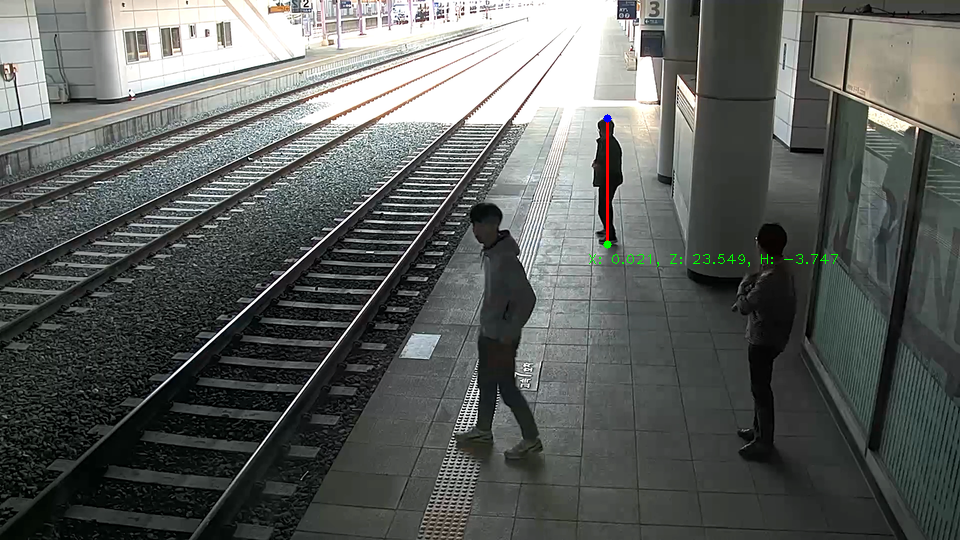

In [28]:
from google.colab.patches import cv2_imshow

# Load an Image
image = cv2.imread(image_path)

contact_point_ori = np.array([607, 118])
head_point_ori = np.array([607, 244])

contact_point = np.array([[contact_point_ori[0] - cx, contact_point_ori[1] - cy, f]],
                          dtype=np.float32)
head_point = np.array([[head_point_ori[0] - cx, head_point_ori[1] - cy, f]],
                      dtype=np.float32)
contact_point = R.T @ contact_point.T
head_point = R.T @ head_point.T
X = contact_point[0] / contact_point[1] * L
Z = contact_point[2] / contact_point[1] * L
Zdot = head_point[2] / head_point[1] * L
H = (Zdot - Z) * L / Zdot

info = f"X: {X[0]:.3f}, Z: {Z[0]:.3f}, H: {H[0]:.3f}"
image = cv2.line(image, contact_point_ori, head_point_ori, (0, 0, 255), 2)
image = cv2.circle(image, contact_point_ori, 4, (255, 0, 0), -1)
image = cv2.circle(image, head_point_ori, 4, (0, 255, 0), -1)
image = cv2.putText(image, info, (head_point_ori[0] - 20, head_point_ori[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0))

cv2_imshow(image)